In [1]:
import numpy as np
import onnxruntime as ort
import cv2
import matplotlib.pyplot as plt

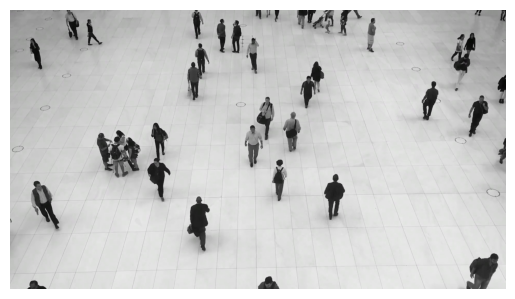

In [2]:
image_bgr = cv2.imread("test.png")
image = cv2.cvtColor(image_bgr , cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

In [3]:
INPUT_SIZE = (384,384) # nano uses (384,384) and small (512, 512) 

def load_and_preprocess_image(image):
    H_orig, W_orig = image.shape[:2]
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, INPUT_SIZE, interpolation=cv2.INTER_CUBIC)

    img = img.astype(np.float32) / 255.0

    # using imagenet's mean and std, mentioned in rfdetr's repo
    mean =  np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape(1,1,3)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1,1,3)

    img = (img - mean) / std

    img = np.transpose(img, (2,0,1)) 
    img = np.expand_dims(img, axis=0)

    return img, (H_orig, W_orig)

In [4]:
temp_img = np.zeros((384,384,3), np.float32)
temp_img = np.transpose(temp_img, (2,0,1))
temp_img = np.expand_dims(temp_img, axis=0)
print(temp_img.shape)

(1, 3, 384, 384)


In [5]:
session = ort.InferenceSession("output_nano/inference_model_sim.onnx",
                               providers=["CPUExecutionProvider"])
def inference(image):
    outputs = session.run(output_names=None, input_feed={"input": image})
    return outputs

img = image_bgr.copy()
img, orig_hw = load_and_preprocess_image(img)
outputs = inference(img)
outputs

[array([[[0.38236198, 0.7672969 , 0.04243388, 0.1978717 ],
         [0.6534769 , 0.66992056, 0.04366056, 0.1653653 ],
         [0.5423949 , 0.6096306 , 0.03056129, 0.1543281 ],
         ...,
         [0.05415053, 0.6342256 , 0.01650191, 0.0349182 ],
         [0.9534866 , 0.9230438 , 0.04408301, 0.07542408],
         [0.9828648 , 0.95034885, 0.03279445, 0.0786123 ]]], dtype=float32),
 array([[[-6.693164 ,  0.8780422, -5.577772 , ..., -5.3945003,
          -6.539479 , -7.9868135],
         [-6.7278066,  1.147192 , -5.8985577, ..., -5.929277 ,
          -7.0164747, -8.322263 ],
         [-6.7663937,  1.0500832, -4.670324 , ..., -5.699952 ,
          -6.8570747, -8.529751 ],
         ...,
         [-6.7857037, -4.1216884, -5.230175 , ..., -5.6029043,
          -6.319699 , -6.257025 ],
         [-6.9448376, -4.2360806, -4.6888137, ..., -5.1789722,
          -5.025433 , -6.7805166],
         [-7.20376  , -4.048356 , -4.1375093, ..., -5.7005296,
          -7.255717 , -7.24592  ]]], dtype=floa

In [6]:
for i, out in enumerate(outputs):
    out = np.asarray(out)
    print(f"[{i}] shape={out.shape}, dtype={out.dtype}")


[0] shape=(1, 300, 4), dtype=float32
[1] shape=(1, 300, 91), dtype=float32


In [7]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))

In [8]:
def cxcywh_to_xyxy(boxes):
    cx, cy, w, h = boxes.T
    return np.stack([
        cx - w / 2,
        cy - h / 2,
        cx + w / 2,
        cy + h / 2
    ], axis=1)

In [9]:
def postprocess(outputs, original_hw, topk=300, score_thresh=.56):
    boxes = outputs[0][0]   # (Q,4) cxcywh normalized
    logits = outputs[1][0]  # (Q,C)

    Q, C = logits.shape  # Q = number of queries, C = number of classes
    flat = logits.reshape(-1) # (Q*C,)
    probs = sigmoid(flat) # (Q*C,)
    #print(probs.shape)
    
    # filtering 
    k = min(topk, probs.size)
    idx = np.argpartition(-probs, k - 1)[:k]
    idx = idx[np.argsort(-probs[idx])]

    scores = probs[idx]
    keep = scores >= score_thresh
    if not np.any(keep):
        return np.array([]).reshape(0, 4), np.array([]), np.array([])
    
    idx = idx[keep]  
    scores = scores[keep]


    q = idx // C  # Query indices
    class_ids = idx % C   # Class indices

    # Convert to xyxy
    xyxy = cxcywh_to_xyxy(boxes[q])

    H, W = original_hw
    xyxy[:, [0,2]] *= W
    xyxy[:, [1,3]] *= H
    xyxy[:, [0,2]] = np.clip(xyxy[:, [0,2]], 0, W)
    xyxy[:, [1,3]] = np.clip(xyxy[:, [1,3]], 0, H)

    # Filter out invalid boxes
    valid = (xyxy[:, 2] > xyxy[:, 0]) & (xyxy[:, 3] > xyxy[:, 1])
    if not np.any(valid):
        return np.array([]).reshape(0, 4), np.array([]), np.array([])
    
    xyxy = xyxy[valid]
    scores = scores[valid]
    class_ids = class_ids[valid]

    return xyxy, scores, class_ids


In [10]:
def postprocess_person(outputs, orig_hw, topk, score_thresh, person_class_idx=1):
    boxes = outputs[0][0]   # (Q,4) cxcywh normalized
    logits = outputs[1][0]  # (Q,C)

    person_logits = logits[:, person_class_idx]

    # Apply sigmoid to logits 
    probs = sigmoid(person_logits)  # (Q,)

    Q = probs.shape[0]

    # Pre-NMS TopK to stabilize (across all person logits)
    k = min(topk, Q)
    idx = np.argpartition(-probs, k - 1)[:k]
    idx = idx[np.argsort(-probs[idx])]

    scores = probs[idx]
    # Filter by threshold
    keep = scores >= score_thresh
    if not np.any(keep):
        return np.array([]).reshape(0, 4), np.array([]), np.array([])
    
    q = idx[keep] # Query indices (already filtered for class 1)
    scores = scores[keep]
    class_ids = np.full(len(q), person_class_idx, dtype=np.int32)

    xyxy = cxcywh_to_xyxy(boxes[q])

    H, W = orig_hw
    xyxy[:, [0,2]] *= W
    xyxy[:, [1,3]] *= H
    xyxy[:, [0,2]] = np.clip(xyxy[:, [0,2]], 0, W)
    xyxy[:, [1,3]] = np.clip(xyxy[:, [1,3]], 0, H)

    # Filter out invalid boxes
    valid = (xyxy[:, 2] > xyxy[:, 0]) & (xyxy[:, 3] > xyxy[:, 1])
    if not np.any(valid):
        return np.array([]).reshape(0, 4), np.array([]), np.array([])
    
    xyxy = xyxy[valid]
    scores = scores[valid]
    class_ids = class_ids[valid]

    return xyxy, scores, class_ids


In [11]:
boxes_xyxy, scores, class_ids = postprocess_person(outputs, orig_hw, topk=27300, score_thresh=0.15)
print(boxes_xyxy.shape, scores.shape, class_ids.shape)
print(scores[:10], class_ids[:10], boxes_xyxy[:3])

(39, 4) (39,) (39,)
[0.7589976  0.7407909  0.70641637 0.6417507  0.6411129  0.61982584
 0.59325975 0.57965386 0.53638345 0.5312469 ] [1 1 1 1 1 1 1 1 1 1] [[1212.7615   634.2169  1296.5897   812.81146]
 [1012.05927  575.06384 1070.737    741.7382 ]
 [ 693.3985   721.82996  774.8715   935.5314 ]]


(np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5))

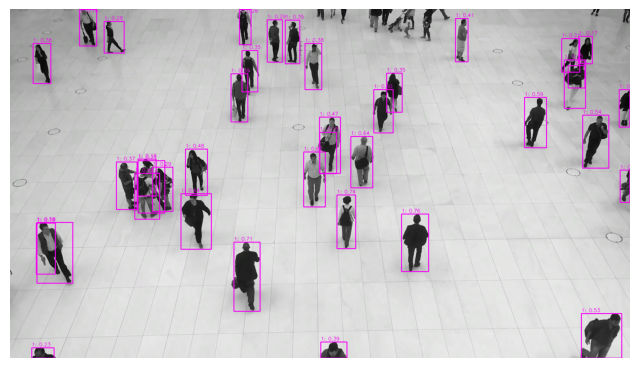

In [12]:
def draw_detections(img, boxes, scores, class_ids):
    img = img.copy()

    for (x1, y1, x2, y2), score, cls in zip(boxes, scores, class_ids):

        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

        cv2.rectangle(img, (x1, y1), (x2, y2), (245, 0, 245), 2)

        label = f"{cls}: {score:.2f}"
        cv2.putText(
            img,
            label,
            (x1, max(y1 - 5, 10)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (245, 0, 245),
            1,
            cv2.LINE_AA
        )

    return img

img = image_bgr.copy()

vis = draw_detections(
    img,
    boxes_xyxy,
    scores,
    class_ids)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")